In [243]:
import numpy as np 
import networkx as nx 
from collections import deque
import random 
from abc import ABC, abstractmethod
from scipy.sparse.linalg import eigsh

def reservoir_sample(iterable, k):
    '''Uniformly samples elements from iterable without replacement.
    '''
    reservoir = []
    for i, item in enumerate(iterable):
        if i < k:
            reservoir.append(item)
        else:
            j = random.randint(0, i)
            if j < k:
                reservoir[j] = item
    return reservoir

class Chain(ABC):
    def __init__(self, seed=None):
        self.np_rng = np.random.default_rng(seed)
        self.rng = random.Random()

    def reset(self, seed=None):
        self.np_rng = np.random.default_rng(seed)
        self.rng = random.Random()

        if hasattr(self, 'state'):
            del self.state_nodes

    def __iter__(self):
        return self 
    
    def __next__(self):
        if not hasattr(self, 'state'):
            self.seed_chain()

        subgraph = self.propose()
        self.accept()

        return subgraph 
    
    @abstractmethod
    def seed_chain(self):
        pass 

    @abstractmethod
    def propose(self):
        pass 

    @abstractmethod
    def accept(self):
        pass

class GraphChain(Chain):
    def __init__(self, network, n_nodes, n_changes=3, seed=None):
        super().__init__(seed)
        self.network = network
        self.n_nodes = n_nodes 
        self.n_changes = n_changes
        
    def seed_chain(self):
        """Seeds the Markov Chain with an initial graph. 
        """
        nodes = self.rng.sample(sorted(self.network.nodes()), self.n_nodes)
        self.nodes = set(list(nodes))
        self.subgraph = self.network.subgraph(nodes)

    def propose(self):
        """Generates a new subgraph by swapping nodes.
        """
        outter_nodes = (node for node in self.network.nodes() if node not in self.nodes)
        removed = self.rng.sample(list(self.nodes), self.n_changes)
        added = reservoir_sample(outter_nodes, self.n_changes)

        self.delta = self.nodes - set(removed)
        self.delta.update(added)
    
        self.subgraph = self.network.subgraph(self.delta)

        return self.subgraph
    
    def accept(self):
        self.nodes = self.delta 

    def step_metadata(self):
        metadata = {
            'n_nodes': nx.number_of_nodes(self.subgraph),
            'n_edges': nx.number_of_edges(self.subgraph),
            'clustering': nx.average_clustering(self.subgraph),
        }

        return metadata


class MetropolisSampler:
    def __init__(self, chain, score_fn, beta=float('inf'), burn_in=0, thinning=1, log_metadata=False):
        """
        Metropolis-Hastings sampler using a proposal chain and user-defined score function.

        Parameters
        ----------
        chain : Chain
            An object implementing the Chain interface (seed_chain, propose, etc.).
        score_fn : Callable
            A function that takes a state (e.g., a graph) and returns a real-valued score.
        burn_in : int, optional
            Number of initial proposals to discard.
        thinning : int, optional
            Collect one sample every `thinning` accepted moves.
        log_metadata : bool, optional
            If True, stores per-step metadata if chain defines `.step_metadata()`.
        """
        self.chain = chain
        self.score_fn = score_fn
        self.beta = beta
        self.burn_in = burn_in
        self.thinning = thinning
        self.log_metadata = log_metadata

        self.accepted = 0
        self.total_steps = 0

        self.scores = []           # score of accepted/thinned samples
        self.trace_scores = []     # score of all proposed states
        self.trace_accepts = []    # list of booleans: was each proposal accepted?
        self.metadata = []         # optional metadata from the chain

    def sample(self, n_samples):
        """
        Run the sampler to collect `n_samples` after burn-in and thinning.

        Returns
        -------
        samples : list
            List of sampled states.
        """
        samples = []
        current = next(self.chain)
        current_score = self.score_fn(current)

        # Burn-in phase
        for _ in range(self.burn_in):
            proposed = self.chain.propose()
            proposed_score = self.score_fn(proposed)
            accepted = self._accept(proposed_score, current_score)
            if accepted:
                current, current_score = proposed, proposed_score
                self.chain.accept()

        # Main sampling phase
        while len(samples) < n_samples:
            proposed = self.chain.propose()
            proposed_score = self.score_fn(proposed)
            self.trace_scores.append(proposed_score)

            accepted = self._accept(proposed_score, current_score)
            self.trace_accepts.append(accepted)

            if accepted:
                current = proposed
                current_score = proposed_score
                self.accepted += 1
                self.chain.accept()

            self.total_steps += 1

            if self.total_steps % self.thinning == 0:
                samples.append(current)
                self.scores.append(current_score)

                if self.log_metadata and hasattr(self.chain, "step_metadata"):
                    self.metadata.append(self.chain.step_metadata())

        return samples

    def _accept(self, proposed_score, current_score):
        """Metropolis acceptance rule."""
        log_alpha = proposed_score - current_score
        return np.log(self.chain.rng.random()) <  -self.beta * log_alpha

    def acceptance_rate(self):
        """Return the acceptance rate (accepted proposals / total steps)."""
        if self.total_steps == 0:
            return 0.0
        return self.accepted / self.total_steps

    def plot_trace(self):
        """Plot the score trace of proposed and accepted states."""
        import matplotlib.pyplot as plt

        plt.figure(figsize=(10, 4))
        plt.plot(self.trace_scores, label="Proposed scores", alpha=0.2)
        plt.plot(
            [i * self.thinning for i in range(len(self.scores))],
            self.scores,
            label="Accepted sample scores",
            marker="o",
            marker_size=2.0,
            linestyle="None",
        )
        plt.xlabel("Step")
        plt.ylabel("Score")
        plt.title("Score Trace During Sampling")
        plt.legend()
        plt.tight_layout()
        plt.show()

def spectral_radius(G):
    """
    Compute the spectral radius (largest absolute eigenvalue) of an undirected graph G
    using sparse matrices and the scipy.sparse.linalg.eigs function.

    For a large adjacency matrix, this might still be somewhat expensive. If performance
    is an issue, consider caching or trying faster approximations.
    """
    # Convert to a scipy CSR sparse matrix
    A = nx.to_scipy_sparse_array(G, nodelist=sorted(G.nodes()), format='csr', dtype=float)

    # Compute the largest eigenvalue in magnitude (k=1, which='LM')
    # eigs returns complex eigenvalues, even for real symmetric; take real part.
    vals = eigsh(A, k=1, which='LM', return_eigenvectors=False)
    val_max = np.real(vals[0])
    return abs(val_max)




In [241]:
from scipy.sparse import load_npz
import networkx as nx 
A = load_npz('../workflows/data/networks/hamsterster/graph_adjacency.npz')
G_large = nx.from_scipy_sparse_array(A)
rad = spectral_radius(G_large)

def spectral_score(subgraph):
    return abs(spectral_radius(subgraph) - rad) 

def large_radius(subgraph):
    '''Penalizes small spectral radius
    '''
    return -spectral_radius(subgraph)

sampler = MetropolisSampler(
    GraphChain(G_large, 200,n_changes=30),
    large_radius,
    burn_in=5000,
    thinning=5,
    beta=100,
    log_metadata=True,
)


In [244]:
samples = sampler.sample(2000)

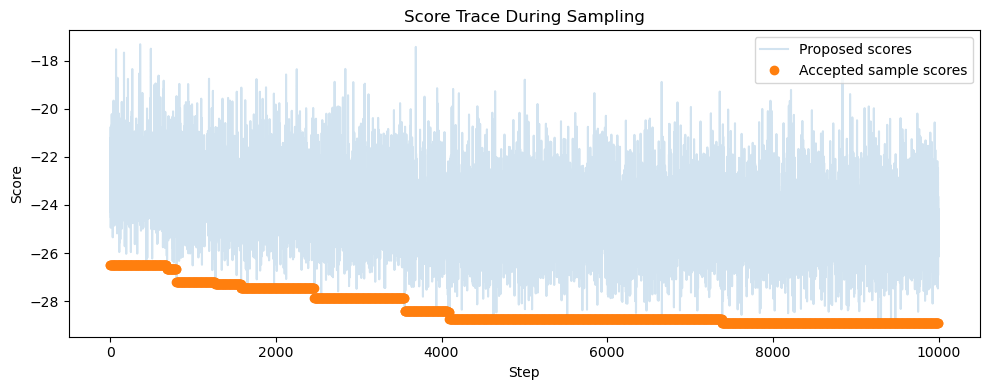

In [245]:
sampler.plot_trace()

In [192]:
pos = nx.forceatlas2_layout(G_large, seed=42, max_iter=200)  # deterministic layout

In [246]:

node_counts = {node: 0 for node in G_large.nodes()}

# Count how many times each node appears in the samples
for subgraph in samples:
    for node in subgraph.nodes():
        node_counts[node] += 1

# Normalize counts to [0, 1] range
counts = np.array(list(node_counts.values()), dtype=float)
max_count = max(counts)
node_alpha = {node: float(count / max_count) if max_count > 0 else 0.0 for node, count in node_counts.items()}



Text(0.5, 1.0, 'Node Inclusion Frequency in Sampled Subgraphs')

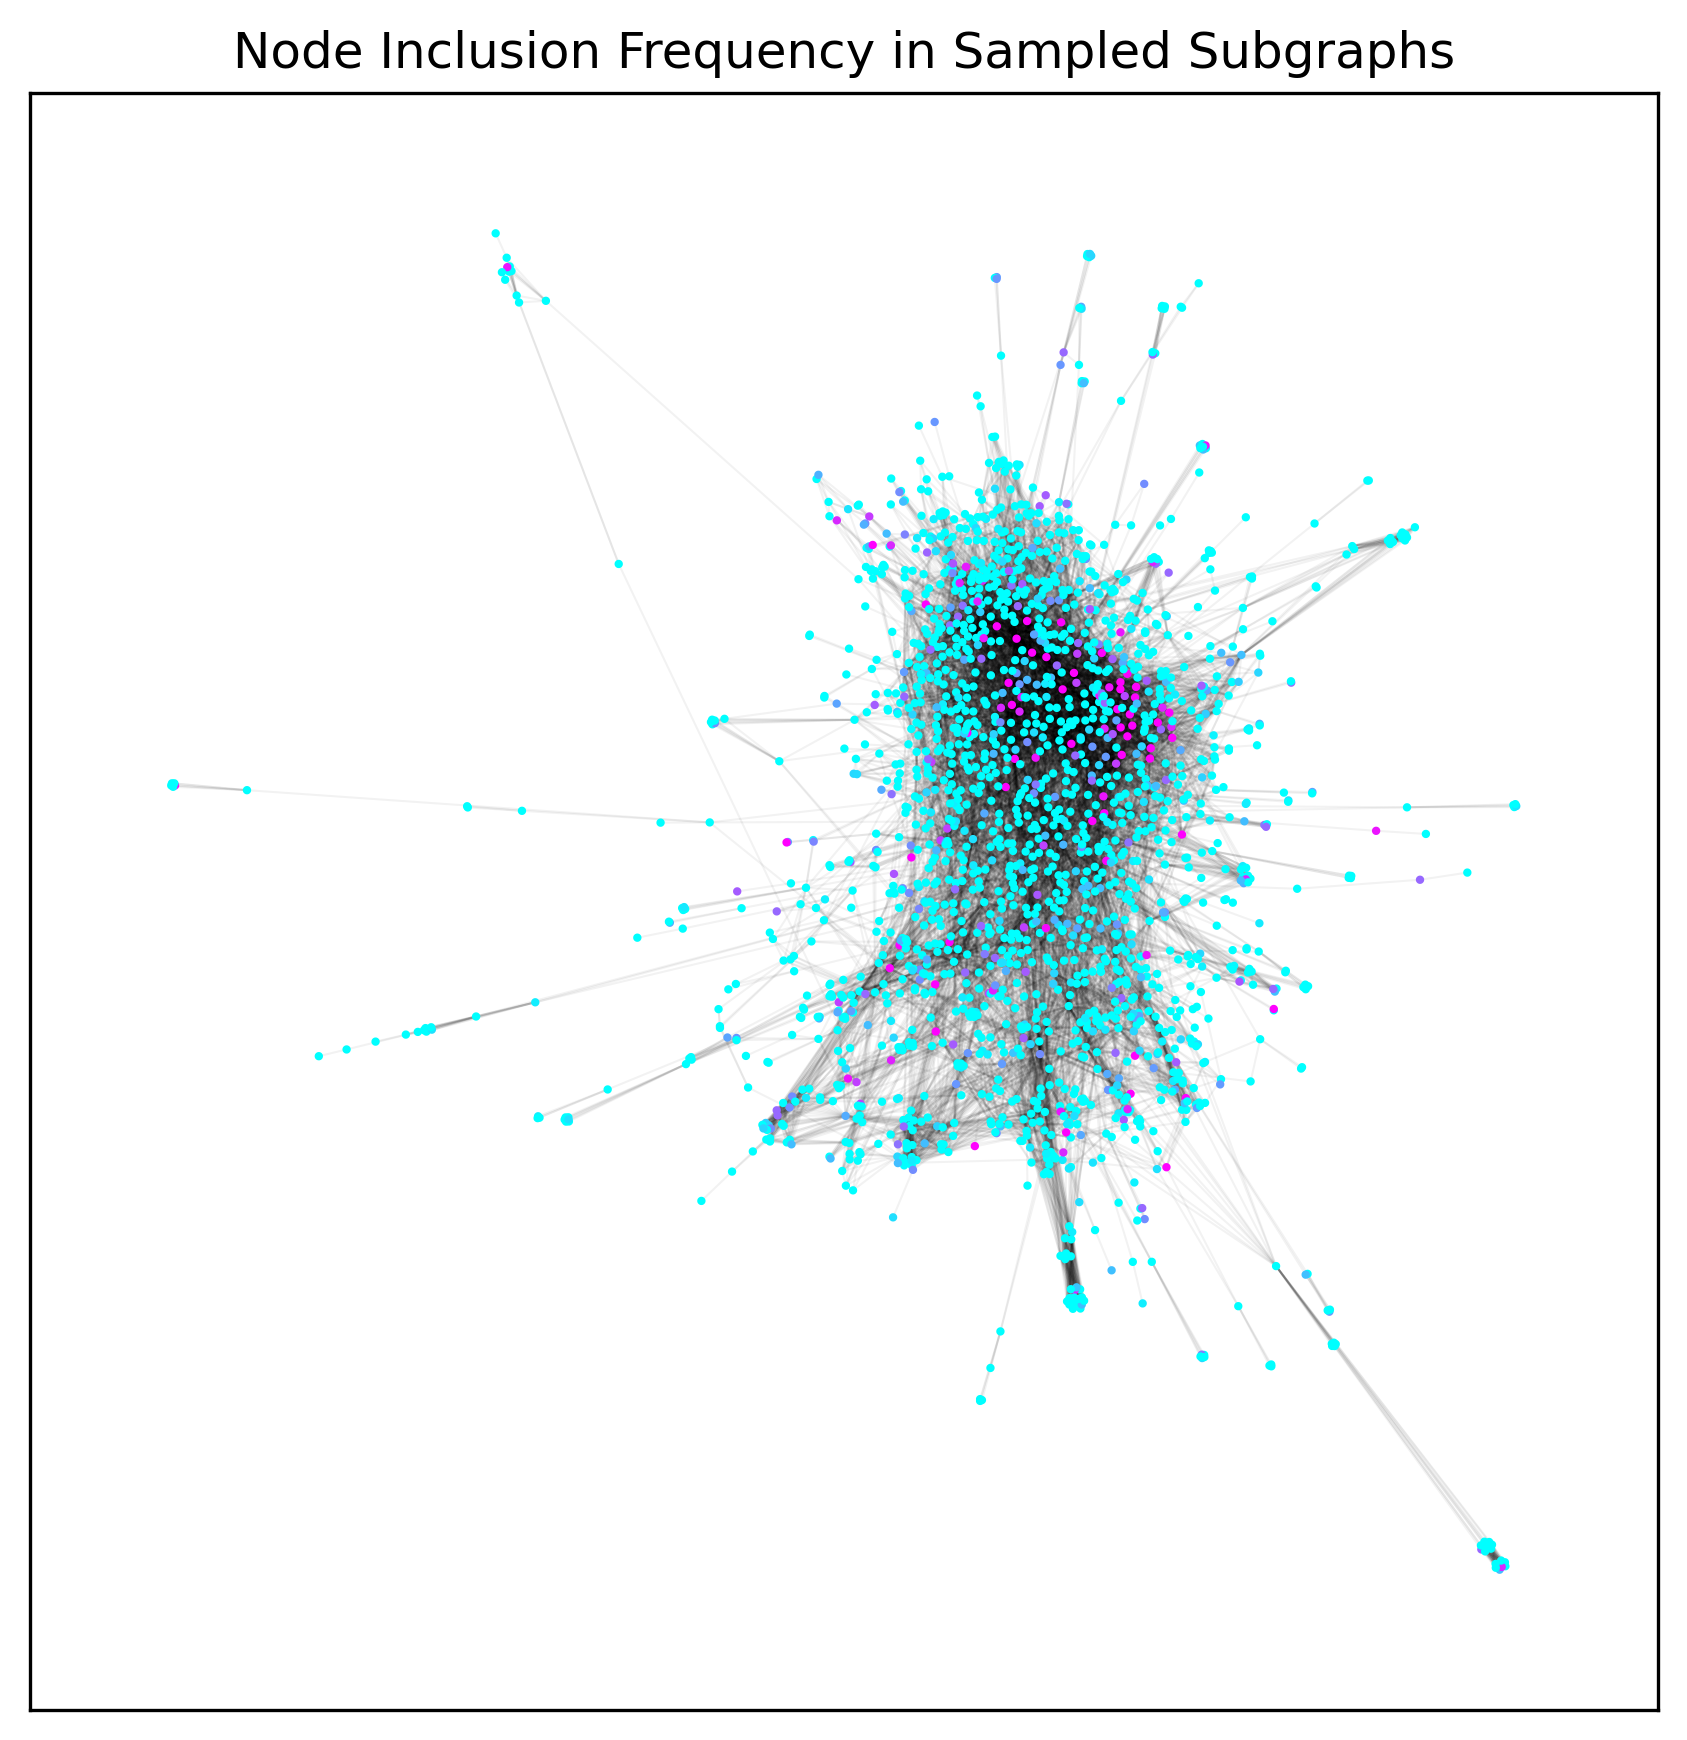

In [247]:
# Draw with transparency (alpha) mapped to normalized counts
fig, ax = plt.subplots(dpi=300, figsize=(7,7))

nx.draw_networkx_nodes(
    G_large, 
    pos,
    node_size=1,
    node_color=node_alpha.values(),
    cmap=plt.get_cmap('cool')
)

nx.draw_networkx_edges(
    G_large,
    pos,
    width=0.5,
    alpha=0.05
)

ax.set_title("Node Inclusion Frequency in Sampled Subgraphs")

In [128]:
import mesa
from mesa.space import NetworkGrid
import networkx as nx 


class IndividualAgent(mesa.Agent):
    def __init__(self, model, compartment, node):
        super().__init__(model)
        self.compartment = compartment
        self._compartment = None 
        self.node = node

    def compute_state(self):
        '''Computes what the next state of the agent should be
        '''
        match self.compartment:
            case "S":
                # Get neighbors of agent
                neighbors = self.model.network.get_neighbors(self.node)

                # Count infected neighbors
                n_infected = 0 
                for neighbor in neighbors:
                    n_infected += 1 if neighbor.compartment == "I" else 0

                # Update state according to probability 
                p_infected = 1 - (1 - self.model.beta) ** n_infected

                if self.model.random.random() < p_infected:
                    self._compartment = "I"

                    self.model.compartment_count["S"] -= 1
                    self.model.compartment_count["I"] += 1
                else:
                    self._compartment = "S" 
            
            case "I":
                # Calculate probability of recovery
                if self.model.random.random() < self.model.gamma:
                    self._compartment = "R" 

                    self.model.compartment_count["I"] -= 1
                    self.model.compartment_count["R"] += 1

            case _:
                # Recovered individuals remain recovered
                pass

    def update_state(self):
        '''Updates state to the previously computed state
        '''
        self.compartment = self._compartment 


class SIRModel(mesa.Model):
    def __init__(self, beta, gamma, network, n_infected=1, seed=None):
        super().__init__(seed=seed)

        self.n_agents = network.number_of_nodes()
        self.beta = beta 
        self.gamma = gamma

        # Initialize compartment count
        self.compartment_count = dict.fromkeys(["S","I","R"], 0)
        self.compartment_count["S"] = self.n_agents - n_infected
        self.compartment_count["I"] = n_infected

        # Create agents
        compartments = ["S"] * (self.n_agents - n_infected) + ["I"] * n_infected
        self.random.shuffle(compartments)

        agents = IndividualAgent.create_agents(
            self,
            n=self.n_agents,
            compartment=compartments,
            node=list(range(self.n_agents))
        )

        # Create network and add agents to network
        self.network = NetworkGrid(network)
        for agent in agents: 
            self.network.place_agent(agent, agent.node)

        self.datacollector = mesa.DataCollector(
            model_reporters={
                'S': lambda m: m.compartment_count['S'],
                'I': lambda m: m.compartment_count['I'],
                'R': lambda m: m.compartment_count['R'],
            }
        )

    def step(self):
        """Advances the model one time step
        """ 
        self.datacollector.collect(self)
        self.agents.do('compute_state') 
        self.agents.do('update_state')

def run_sir(sir_model, max_iter=100):
    '''Run SIR until convergence
    '''
    t = 0

    while (sir_model.compartment_count['I'] > 0) and (t < max_iter):
        sir_model.step()
        t += 1

        

In [129]:
import networkx as nx

network = nx.erdos_renyi_graph(100,0.1)

sir = SIRModel(0.1,0.1,network)

run_sir(sir)

<Axes: >

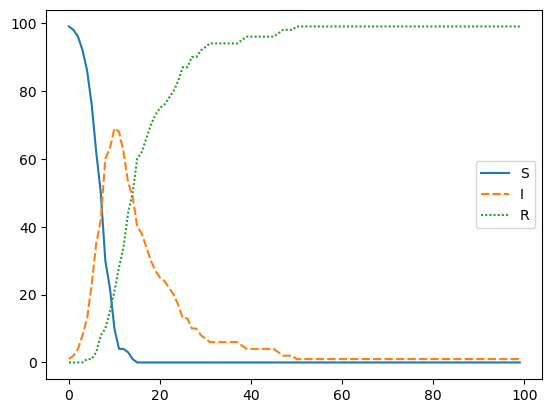

In [132]:
import pandas as pd 
import seaborn as sns
count = sir.datacollector.get_model_vars_dataframe()
count

sns.lineplot(
    count
)



In [3]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigs

# -----------------------------------------------------------------------------------------
# 2. Main: generate the large graph and set up the subgraph
# -----------------------------------------------------------------------------------------
def simulated_annealing_subgraph_spectral(
    G_large, # The original graph to miniaturize
    subgraph_size=200,      # The size of the subgraph
    max_iter=50000,          # Maximum number of iterations
    T0=1.0, alpha=0.9999,     # Initial temperature and cooling rate
    target_tolerance=0.01   # Stop if we get this close to target radius
):
    """
    1) Generate a Barabasi-Albert graph with n_large nodes.
    2) Compute its spectral radius -> 'target_radius'.
    3) Randomly pick 'subgraph_size' nodes => induced subgraph => 'current_graph'.
    4) Repeatedly propose a small change (swap 1 node in subgraph with 1 node out)
       and decide acceptance with the Metropolis criterion based on
       |specRadius(current) - target_radius|.
    5) Return the subgraph with the best match and logging info.
    """

    # Compute spectral radius of the large graph
    print("Computing spectral radius of the large graph ...")
    target_radius = spectral_radius(G_large)
    print(f"Target spectral radius (large graph): {target_radius:.4f}")

    # -------------------- Step 2: Create initial subgraph of size 500 --------------------
    all_nodes = sorted(list(G_large.nodes()))
    # pick random subgraph
    np.random.seed(42)   # for reproducibility
    chosen_nodes = set(np.random.choice(all_nodes, size=subgraph_size, replace=False))
    current_subgraph = G_large.subgraph(chosen_nodes).copy()

    current_radius = spectral_radius(current_subgraph)
    current_loss = abs(current_radius - target_radius)

    print(f"Initial subgraph spectral radius: {current_radius:.4f}, loss={current_loss:.4f}")

    # Keep track of the best solution found
    best_loss = current_loss
    best_nodes = chosen_nodes.copy()
    best_radius = current_radius

    # For logging
    radii_over_time = [current_radius]
    losses_over_time = [current_loss]
    temps_over_time = [T0]

    # Convert sets for fast membership
    not_in_subgraph = set(all_nodes) - chosen_nodes

    # -------------------- Step 3: Simulated Annealing Loop --------------------
    T = T0
    for i in range(max_iter):
        # 3a) Cooling schedule
        #     e.g., T = T0 * alpha^i, or T0/(1 + i) etc.
        T = T * alpha if i > 0 else T0

        # 3b) Propose a random 'swap': remove one node from subgraph, add one from outside
        out_node = np.random.choice(list(chosen_nodes))
        in_node = np.random.choice(list(not_in_subgraph))

        # Build a candidate subgraph to test
        new_subgraph_nodes = chosen_nodes.copy()
        new_subgraph_nodes.remove(out_node)
        new_subgraph_nodes.add(in_node)
        # Construct the induced subgraph
        candidate_subgraph = G_large.subgraph(new_subgraph_nodes).copy()
        # Evaluate new subgraph spectral radius
        candidate_radius = spectral_radius(candidate_subgraph)
        candidate_loss = abs(candidate_radius - target_radius)

        # 3c) Decide acceptance via Metropolis
        delta_loss = candidate_loss - current_loss
        if (delta_loss < 0):
            # better solution => accept
            accept = True
        else:
            # accept with probability exp(-delta_loss / T)
            accept = (np.random.rand() < np.exp(-delta_loss / T))

        if accept:
            chosen_nodes = new_subgraph_nodes
            current_loss = candidate_loss
            current_radius = candidate_radius
            not_in_subgraph = set(all_nodes) - chosen_nodes

        # Record if new best
        if current_loss < best_loss:
            best_loss = current_loss
            best_nodes = chosen_nodes.copy()
            best_radius = current_radius

        radii_over_time.append(current_radius)
        losses_over_time.append(current_loss)
        temps_over_time.append(T)

        # 3d) Stop early if close enough
        if best_loss < target_tolerance:
            print(f"Stopping early at iteration {i}. Achieved loss={best_loss:.4f}.")
            break

        # Print occasional progress
        if i % 50 == 0:
            print(f"Iter={i}, T={T:.4e}, CurrentLoss={current_loss:.4f}, BestLoss={best_loss:.4f}")

    # Final chosen subgraph
    final_subgraph = G_large.subgraph(best_nodes).copy()

    return {
        'G_large': G_large,
        'target_radius': target_radius,
        'final_subgraph': final_subgraph,
        'final_subgraph_radius': spectral_radius(final_subgraph),
        'best_loss': best_loss,
        'best_radius': best_radius,
        'radii_over_time': radii_over_time,
        'temps_over_time': temps_over_time
    }


# -----------------------------------------------------------------------------------------
# 3. Run the procedure and create plots
# -----------------------------------------------------------------------------------------

results = simulated_annealing_subgraph_spectral(
    G_large=G_large,
    subgraph_size=200,
    max_iter=10000,        # fewer iterations for demo; you can increase for better result
    T0=1.0,
    alpha=0.98,
    target_tolerance=0.01
)

G_large            = results['G_large']
final_subgraph     = results['final_subgraph']
target_radius      = results['target_radius']
final_subgraph_rad = results['final_subgraph_radius']
best_loss          = results['best_loss']
best_rad           = results['best_radius']
radii_over_time    = results['radii_over_time']
temps_over_time    = results['temps_over_time']

print("\n=== Results ===")
print(f"Target radius (large graph): {target_radius:.4f}")
print(f"Final subgraph radius:       {final_subgraph_rad:.4f}")
print(f"Final best loss:             {best_loss:.4f}")




Computing spectral radius of the large graph ...
Target spectral radius (large graph): 50.0214
Initial subgraph spectral radius: 6.4350, loss=43.5864
Iter=0, T=1.0000e+00, CurrentLoss=43.5864, BestLoss=43.5864
Iter=50, T=3.6417e-01, CurrentLoss=42.7887, BestLoss=42.7887
Iter=100, T=1.3262e-01, CurrentLoss=42.5388, BestLoss=42.4884
Iter=150, T=4.8296e-02, CurrentLoss=41.8126, BestLoss=41.8126
Iter=200, T=1.7588e-02, CurrentLoss=40.2634, BestLoss=40.2634
Iter=250, T=6.4050e-03, CurrentLoss=40.1442, BestLoss=40.1442
Iter=300, T=2.3325e-03, CurrentLoss=39.5566, BestLoss=39.5566
Iter=350, T=8.4943e-04, CurrentLoss=39.1760, BestLoss=39.1760
Iter=400, T=3.0934e-04, CurrentLoss=38.5023, BestLoss=38.5023
Iter=450, T=1.1265e-04, CurrentLoss=37.0067, BestLoss=37.0067
Iter=500, T=4.1024e-05, CurrentLoss=36.7989, BestLoss=36.7989
Iter=550, T=1.4940e-05, CurrentLoss=36.1945, BestLoss=36.1945
Iter=600, T=5.4406e-06, CurrentLoss=36.0072, BestLoss=36.0072
Iter=650, T=1.9813e-06, CurrentLoss=35.0168, Be

## Analysis

In [4]:
# Compute the layout of the graph
layout = nx.forceatlas2_layout(G_large, max_iter=300)

Drawing the graph and its core

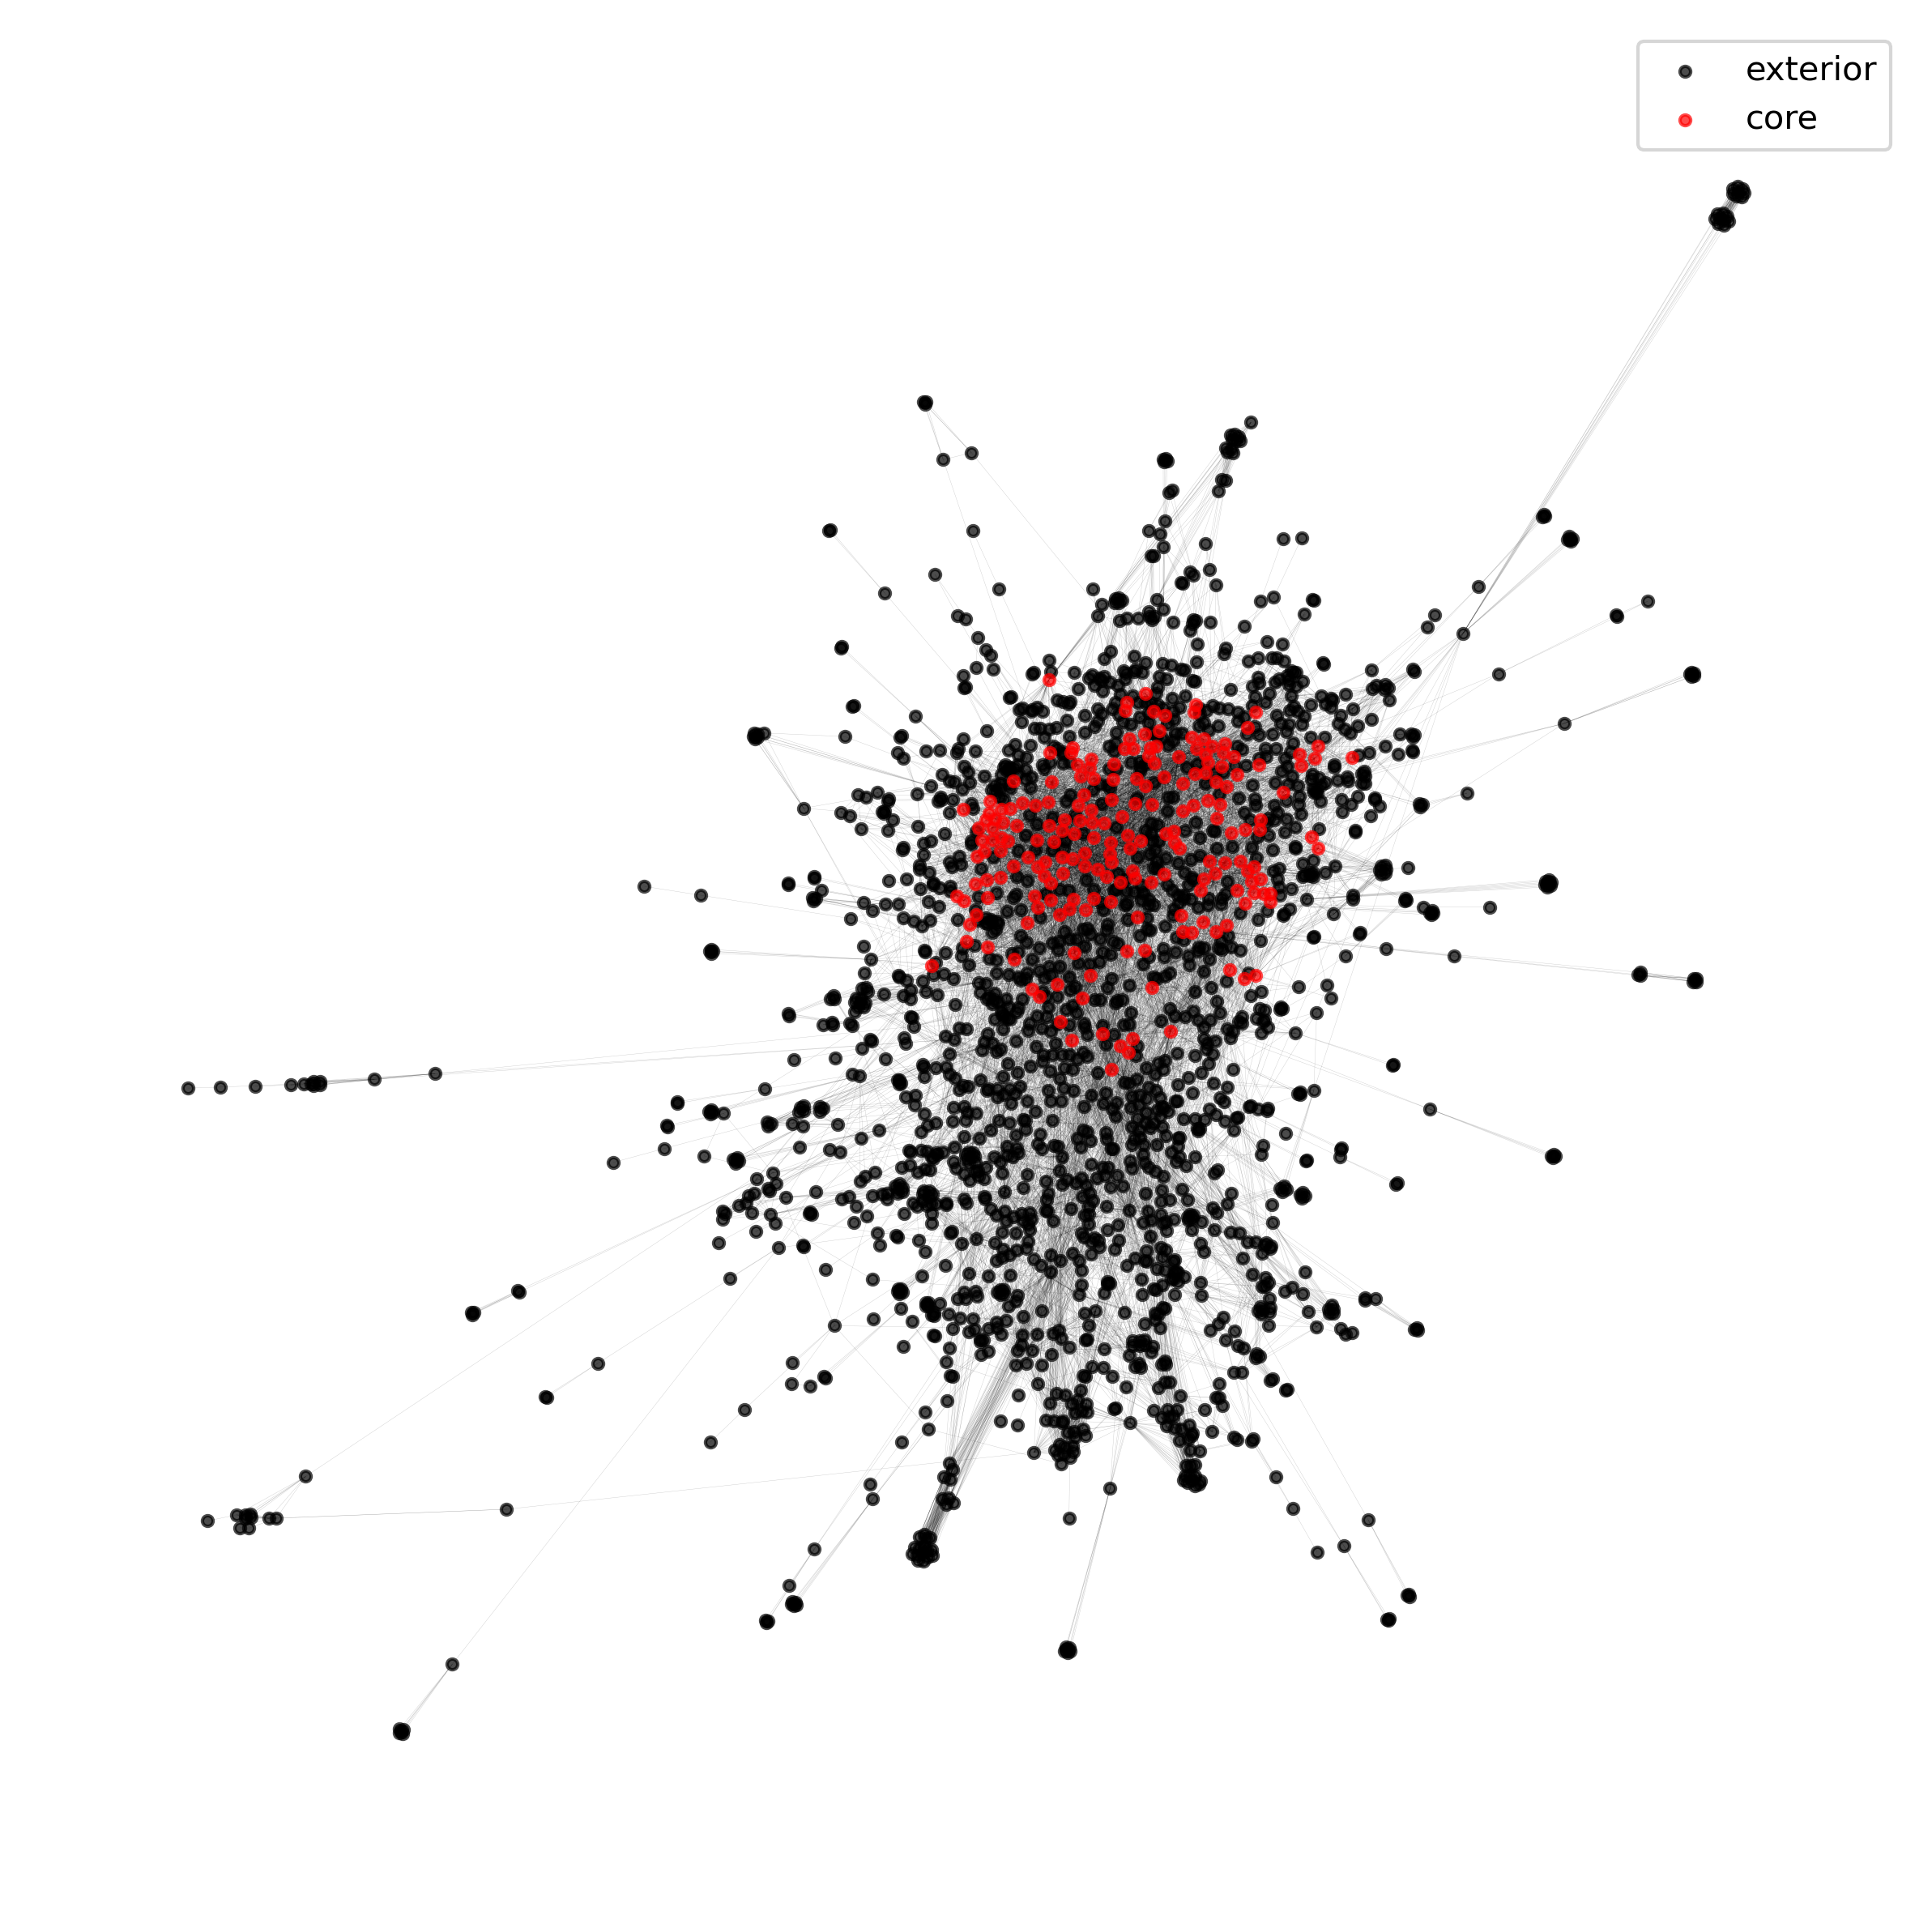

In [5]:
fig, ax = plt.subplots(dpi=300,figsize=(10,10))

interior = set(final_subgraph.nodes()) 
exterior = set(G_large.nodes()) - interior 

# Draw exterior nodes
nx.draw_networkx_nodes(
    G_large,
    layout,
    exterior,
    node_size=10,
    node_color='k',
    alpha=0.7,
    label='exterior'
)

# Draw interior nodes
nx.draw_networkx_nodes(
    G_large,
    layout,
    interior,
    node_size=10,
    node_color='r',
    alpha=0.7,
    label='core'
)

# Draw edges
nx.draw_networkx_edges(
    G_large,
    layout,
    width=0.1,
    alpha=0.2
)

ax.set_axis_off()
ax.legend()

plt.savefig('core.png',transparent=True)

In [6]:
G_exterior = G_large.subgraph(exterior).copy()

graphs = [G_large,final_subgraph, G_exterior]
print('Fraction of edges:', final_subgraph.number_of_edges()/G_large.number_of_edges())
print('Spectral radius of exterior:', spectral_radius(G_exterior))
print('Connected components in exterior:', nx.number_connected_components(G_exterior))
print('Average Clustering:', *(nx.average_clustering(g) for g in graphs))
print('Overall Clsutering:', *(overall_clustering(g) for g in graphs))

Fraction of edges: 0.201155494812698
Spectral radius of exterior: 30.536579470495916
Connected components in exterior: 103
Average Clustering: 0.5399779368195855 0.4433096212061304 0.5469725246964953
Overall Clsutering: 0.39008098900606303 0.3929153813066952 0.5108797701776432


In [ ]:
measurements = []
for nodes in nx.connected_components(G_exterior):
    graph = G_large.subgraph(nodes).copy()

    measurements.append({
        'n_nodes': graph.number_of_nodes(),
        'n_edges': graph.number_of_edges(),
        'density': nx.density(graph),
        'clustering': nx.average_clustering(graph)
    })

NameError: name 'final_subgraph' is not defined

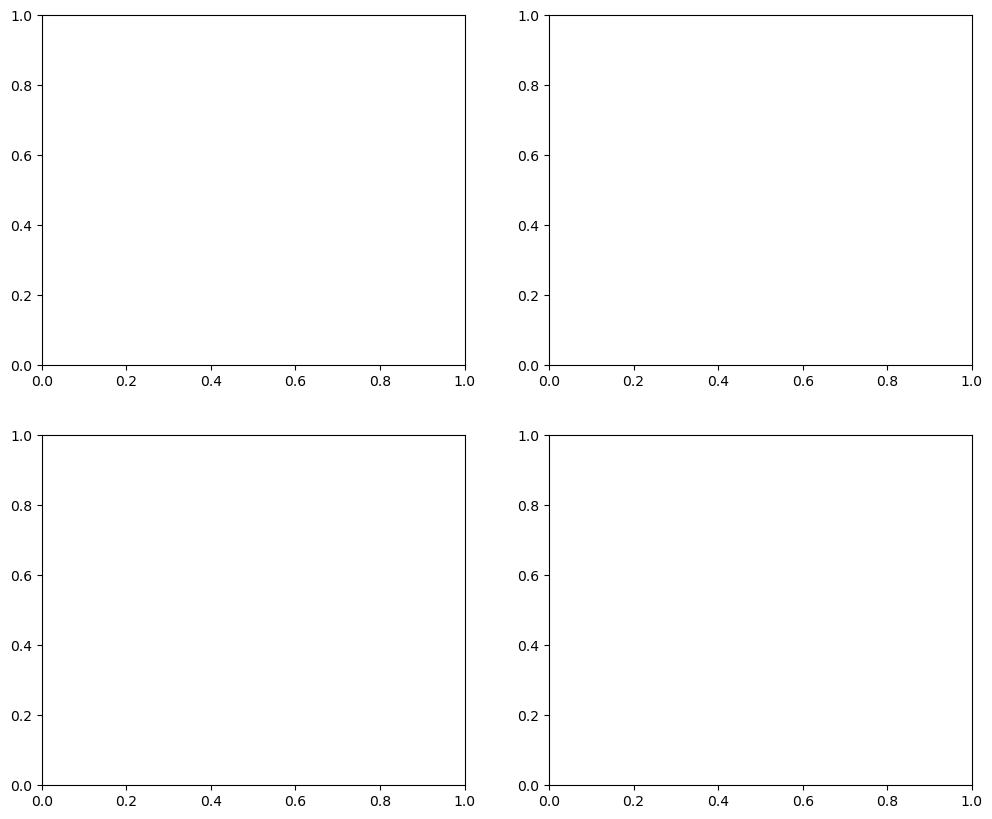

In [24]:
# ------- PLOTS -------
fig, axs = plt.subplots(2, 2, figsize=(12,10))
ax1, ax2, ax3, ax4 = axs.ravel()

# # Plot 1: Large Graph vs. Subgraph side by side
# # NOTE: Plotting 5000 nodes is usually quite messy, but here's a demonstration:
# pos_large = nx.spring_layout(G_large, seed=42)
# nx.draw_networkx_nodes(G_large, pos_large, ax=ax1, node_size=10, alpha=0.5)
# nx.draw_networkx_edges(G_large, pos_large, ax=ax1, alpha=0.1)
# ax1.set_title("Original Large Graph (5,000 nodes)")
# ax1.axis('off')

# For subgraph
pos_sub = nx.spring_layout(final_subgraph, seed=42)
nx.draw_networkx_nodes(final_subgraph, pos_sub, ax=ax2, node_size=30, alpha=0.8, node_color='red')
nx.draw_networkx_edges(final_subgraph, pos_sub, ax=ax2, alpha=0.3, edge_color='gray')
ax2.set_title("Final Subgraph (500 nodes)")
ax2.axis('off')

# Plot 2: Temperature vs. iteration
ax3.plot(temps_over_time, label='Temperature')
ax3.set_xlabel('Iteration')
ax3.set_ylabel('Temperature')
ax3.set_title('Annealing Schedule')
ax3.legend()

# Plot 3: Spectral radius over time
ax4.plot(radii_over_time, label='Subgraph Spectral Radius')
ax4.axhline(y=target_radius, color='r', linestyle='--', label='Target Radius')
ax4.set_xlabel('Iteration')
ax4.set_ylabel('Spectral Radius')
ax4.set_title('Spectral Radius vs. Iteration')
ax4.legend()

plt.tight_layout()
plt.show()

# Next: distribution of spectral radius values over time
# (We only tracked the subgraph radius at each step in 'radii_over_time')
plt.figure(figsize=(6,4))
plt.hist(radii_over_time, bins=30, alpha=0.7, edgecolor='black')
plt.axvline(x=target_radius, color='r', linestyle='--', label='Target')
plt.title("Distribution of Subgraph Spectral Radius Values")
plt.xlabel("Spectral Radius")
plt.ylabel("Frequency")
plt.legend()
plt.show()

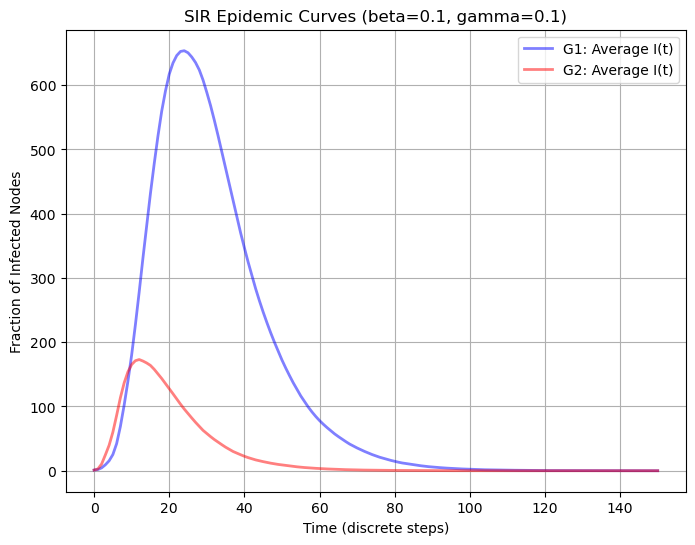

In [117]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

def run_SIR_discrete_simulation(G, beta, gamma, max_steps=50, initial_infected=None):
    """
    Runs ONE discrete-time SIR simulation on graph G.
    
    - G: NetworkX graph (undirected)
    - beta: Transmission probability per edge (per time step)
    - gamma: Recovery probability per infected node (per time step)
    - max_steps: Maximum discrete time steps to simulate
    - initial_infected: (Optional) list or set of infected node IDs at t=0
                       If None, we pick 1 random node to infect.

    Returns:
        - infected_fraction (list of length t+1 <= max_steps+1)
          infected_fraction[t] = fraction of nodes that are in the I state at time t
    """
    # Initialize S, I, R sets
    all_nodes = list(G.nodes())
    N = len(all_nodes)

    if initial_infected is None:
        # Infect exactly 1 random node for demonstration
        initial_infected = {np.random.choice(all_nodes)}
    else:
        initial_infected = set(initial_infected)

    S = set(all_nodes) - initial_infected
    I = set(initial_infected)
    R = set()  # recovered

    # Track fraction infected over time
    infected_fraction = []
    infected_fraction.append(len(I) / N)

    for step in range(max_steps):
        if len(I) == 0:
            # No more infected -> epidemic died out
            break

        new_I = set()
        new_R = set()

        # 1) Infections
        for inf_node in I:
            # For each infected node, attempt to infect neighbors
            neighbors = G[inf_node]
            for nbr in neighbors:
                if nbr in S:
                    # Infect this neighbor with probability beta
                    if np.random.rand() < beta:
                        new_I.add(nbr)

        # 2) Recoveries
        for inf_node in I:
            # Each infected node recovers with probability gamma
            if np.random.rand() < gamma:
                new_R.add(inf_node)

        # Update sets
        S = S - new_I
        I = (I | new_I) - new_R
        R = R | new_R

        infected_fraction.append(len(I) / N)

    return infected_fraction


def estimate_SIR_curves_for_two_graphs(
    G1, G2, beta, gamma, num_simulations=20, max_steps=50
):
    """
    Repeatedly simulates an SIR epidemic on each of two graphs (G1, G2) with the SAME
    parameters beta, gamma, and returns the average infected fraction over time for each.

    - G1, G2: Two NetworkX graphs (undirected)
    - beta, gamma: SIR parameters (transmission probability, recovery probability)
    - num_simulations: number of repeated SIR runs per graph
    - max_steps: maximum discrete timesteps for each run

    Returns:
      (avg_infected_G1, avg_infected_G2, time_axis)
      where each avg_infected_* is a list of average infected fractions at each time step,
      and time_axis is a list [0, 1, 2, ...] for plotting.
    """

    # We’ll store results for each run in a list (which can be ragged if epidemics die early)
    infected_curves_G1 = []
    infected_curves_G2 = []

    for _ in range(num_simulations):
        # Run simulation on G1
        frac_I_G1 = run_SIR_discrete_simulation(
            G1, beta, gamma, max_steps=max_steps, initial_infected=None
        )
        infected_curves_G1.append(frac_I_G1)

        # Run simulation on G2
        frac_I_G2 = run_SIR_discrete_simulation(
            G2, beta, gamma, max_steps=max_steps, initial_infected=None
        )
        infected_curves_G2.append(frac_I_G2)

    # We need to average over runs.
    # The runs can have different lengths if the epidemic dies out sooner in some runs,
    # so we'll align them by time and assume zero infected fraction after the epidemic ends.

    # Find the longest run
    max_len_1 = max(len(c) for c in infected_curves_G1)
    max_len_2 = max(len(c) for c in infected_curves_G2)
    max_len = max(max_len_1, max_len_2)

    # Pad each run with zeros (beyond the last step if it died out)
    # Then average across runs, step by step.
    infected_mat_G1 = np.zeros((num_simulations, max_len))
    infected_mat_G2 = np.zeros((num_simulations, max_len))

    for i in range(num_simulations):
        c1 = infected_curves_G1[i]
        c2 = infected_curves_G2[i]
        infected_mat_G1[i, :len(c1)] = c1
        infected_mat_G2[i, :len(c2)] = c2

    avg_infected_G1 = infected_mat_G1.mean(axis=0)
    avg_infected_G2 = infected_mat_G2.mean(axis=0)
    time_axis = list(range(max_len))

    return avg_infected_G1, avg_infected_G2, time_axis


def plot_SIR_curves_for_two_graphs(G1, G2, beta=0.1, gamma=0.1, num_simulations=20, max_steps=50):
    """
    Runs repeated SIR simulations on G1 and G2, then plots the average infected fraction
    vs time for both graphs on the same plot.
    """
    avg_infected_G1, avg_infected_G2, t_axis = estimate_SIR_curves_for_two_graphs(
        G1, G2,
        beta=beta, gamma=gamma,
        num_simulations=num_simulations,
        max_steps=max_steps
    )

    plt.figure(figsize=(8, 6))
    plt.plot(t_axis, avg_infected_G1 * G1.number_of_nodes(), label='G1: Average I(t)', color='blue', alpha=0.5, linewidth=2.0)
    plt.plot(t_axis, avg_infected_G2 * G2.number_of_nodes(), label='G2: Average I(t)', color='red', alpha=0.5, linewidth=2.0)
    plt.xlabel('Time (discrete steps)')
    plt.ylabel('Fraction of Infected Nodes')
    plt.title(f'SIR Epidemic Curves (beta={beta}, gamma={gamma})')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_SIR_curves_for_two_graphs(G_large, final_subgraph, max_steps=150, num_simulations=300)

In [76]:
metrics = {
    'assortativity': nx.degree_assortativity_coefficient,
    'clustering': nx.average_clustering,
}

for graph in [G_large, final_subgraph]:
    print("Metrics:")
    for metric, function in metrics.items():
        print(f"\t{metric}: {function(graph)}")
    print()

Metrics:
	assortativity: -0.044711799172241135
	clustering: 0.00945612595573412

Metrics:
	assortativity: -0.26842984569988837
	clustering: 0.12201753232600286

